# Cuisine Classification for Recipe Ingredients

## Importing Libraries

In [20]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve,auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
import joblib
import ast
from collections import Counter

## Data Loading

###loading the data required for the cuisine classification project:

- **Training Data**:  
  The `train.json` file is read and converted into a pandas DataFrame (`train_df`). This dataset contains labeled recipes with their corresponding cuisines.

- **Test Data**:  
  The `test.json` file is read and converted into a pandas DataFrame (`test_df`). This dataset contains unlabeled recipes that need to be classified.

In [21]:
with open('../src/input/train.json', 'r') as f:
    cuisine_train = json.load(f)
train_df = pd.DataFrame(cuisine_train)

with open('../src/input/test.json', 'r') as f:
    cuisine_test = json.load(f)
test_df = pd.DataFrame(cuisine_test)

This function creates an interactive table using Plotly, with customizable data, title, and maximum rows, featuring color-coded headers and cells for enhanced readability.

In [22]:
def create_interactive_table(data, title, max_rows=None):
  
    if max_rows is not None:
        df = data.head(max_rows)
    else:
        df = data

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df.columns),
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[df[col] for col in df.columns],
            fill_color='lavender',
            align='left'
        )
    )])
    fig.update_layout(title=title)
    return fig

## Data Tables

- **Training Data**: Makes and shows table of all training data
- **Test Data**: Makes and shows table of all test data

In [23]:
train_table = create_interactive_table(train_df.head(20), "Training Data (All Records)")
train_table.show()

test_table = create_interactive_table(test_df.head(20), "Test Data (All Records)")
test_table.show()

## Data Info Tables
Summary tables for training and test data, showing column details and non-null counts.

In [24]:
def create_info_df(df):
    info = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        non_null = df[col].count()
        info.append([col, dtype, non_null])

    info_df = pd.DataFrame(info, columns=['Column', 'Dtype', 'Non-Null Count'])

    total_row = pd.DataFrame({
        'Column': [f'Total ({len(df)} rows)'],
        'Dtype': [''],
        'Non-Null Count': ['']
    })
    
    return pd.concat([info_df, total_row], ignore_index=True)

#training data table information
train_info_df = create_info_df(train_df)
train_info_table = create_interactive_table(train_info_df, "Information about Training Data")
train_info_table.show()

#test data table information
test_info_df = create_info_df(test_df)
test_info_table = create_interactive_table(test_info_df, "Information about Test Data")
test_info_table.show()

## Missing Values Analysis
Showing the count and percentage of missing values in both training and test datasets.

In [25]:
def create_missing_values_df(train_df, test_df):
    train_missing = train_df.isnull().sum()
    test_missing = test_df.isnull().sum()
    
    missing_data = pd.DataFrame({
        'Column': train_missing.index,
        'Training Data Missing': train_missing.values,
        'Test Data Missing': test_missing.reindex(train_missing.index).fillna(0).astype(int)
    })
    
    missing_data['Training Data Missing (%)'] = (missing_data['Training Data Missing'] / len(train_df) * 100).round(2)
    missing_data['Test Data Missing (%)'] = (missing_data['Test Data Missing'] / len(test_df) * 100).round(2)
    
    return missing_data.sort_values('Training Data Missing', ascending=False)

missing_values_df = create_missing_values_df(train_df, test_df)
missing_values_table = create_interactive_table(missing_values_df, "Missing Values in Training and Test Data")
missing_values_table.show()

## Cuisine Distribution Analysis
Showing the count and percentage of each unique cuisine in the training dataset.

In [26]:
def create_unique_cuisines_df(train_df):
    if 'cuisine' in train_df.columns:
        cuisine_counts = train_df['cuisine'].value_counts().reset_index()
        cuisine_counts.columns = ['Cuisine', 'Count']
        cuisine_counts['Percentage'] = (cuisine_counts['Count'] / len(train_df) * 100).round(2)
        
        return cuisine_counts.sort_values('Count', ascending=False)
    else:
        raise ValueError("The 'cuisine' column is not present in the training data.")

try:
    unique_cuisines_df = create_unique_cuisines_df(train_df)
    unique_cuisines_table = create_interactive_table(unique_cuisines_df, "Unique Cuisines in Training Data")
    unique_cuisines_table.show()
except ValueError as e:
    print(e)

## Cuisine Distribution Visualization
Bar chart showing the distribution of different cuisines in the training dataset.

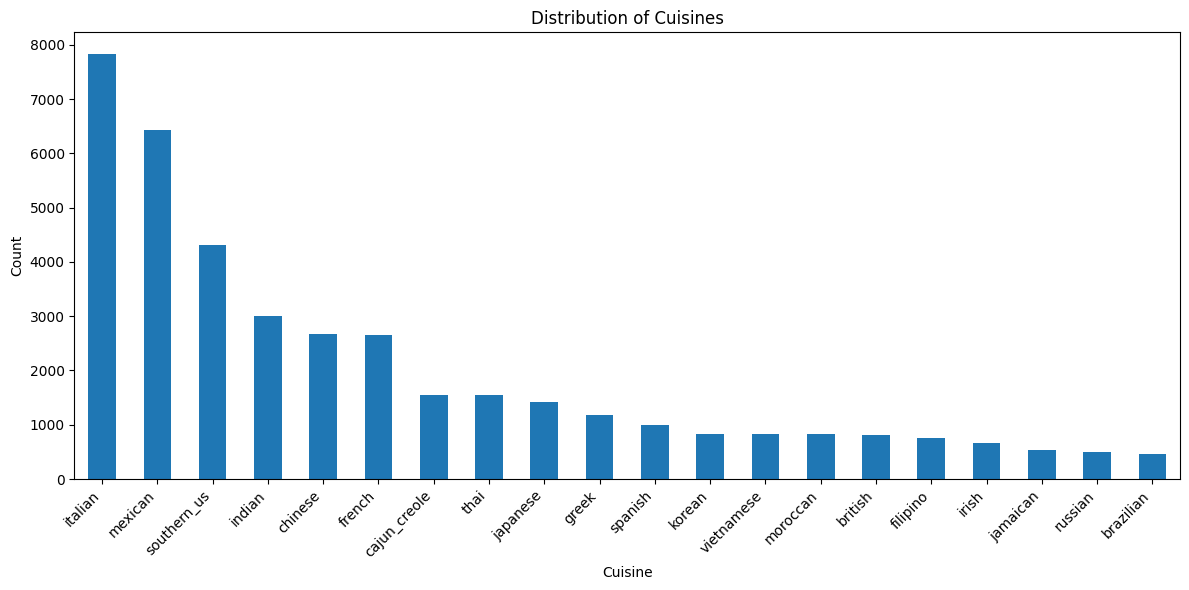

In [27]:
plt.figure(figsize=(12, 6))
train_df['cuisine'].value_counts().plot(kind='bar')
plt.title('Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Ingredients Count Distribution
Histogram showing the distribution of the number of ingredients per recipe in the training dataset.

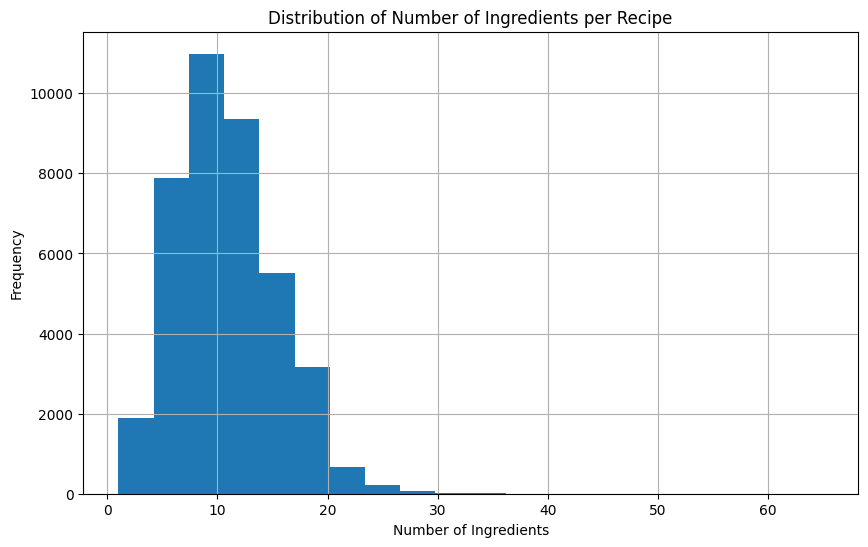

In [28]:
plt.figure(figsize=(10, 6))
train_df['ingredients'].apply(len).hist(bins=20)
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

## Top 10 Ingredients Visualization
Bar chart showing the top 10 most common ingredients in the training dataset along with their frequencies.

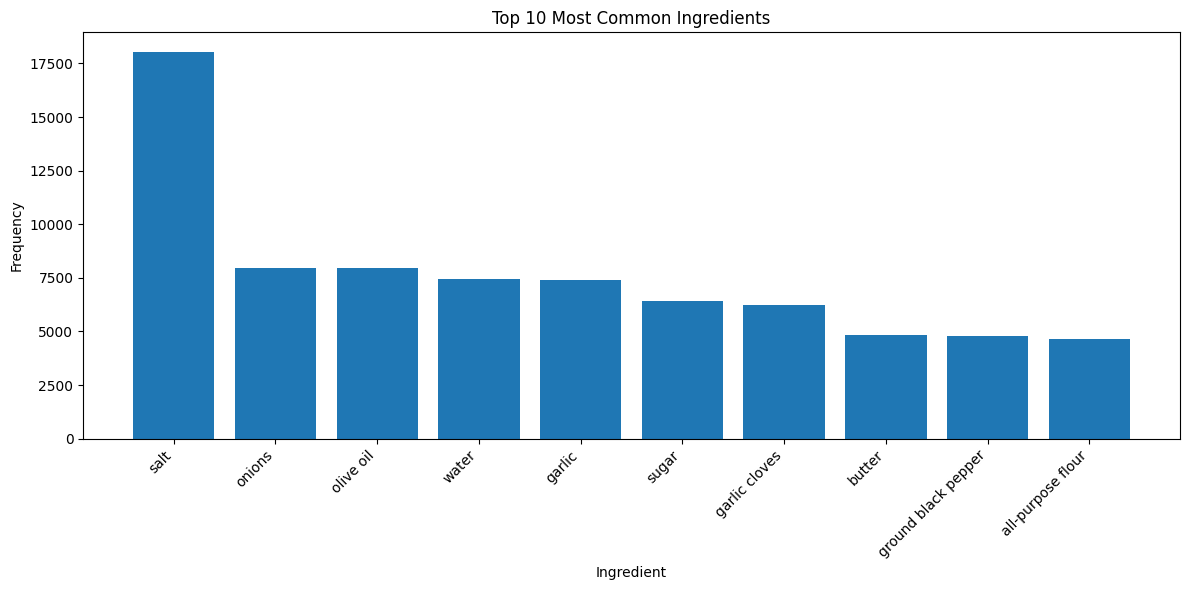

In [29]:
all_ingredients = [item for sublist in train_df['ingredients'] for item in sublist]
ingredient_freq = Counter(all_ingredients)
top_10 = dict(ingredient_freq.most_common(10))

plt.figure(figsize=(12, 6))
plt.bar(top_10.keys(), top_10.values())
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Ingredient')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Average Ingredients by Cuisine
Bar chart showing the average number of ingredients used in recipes for each cuisine type in the training dataset.

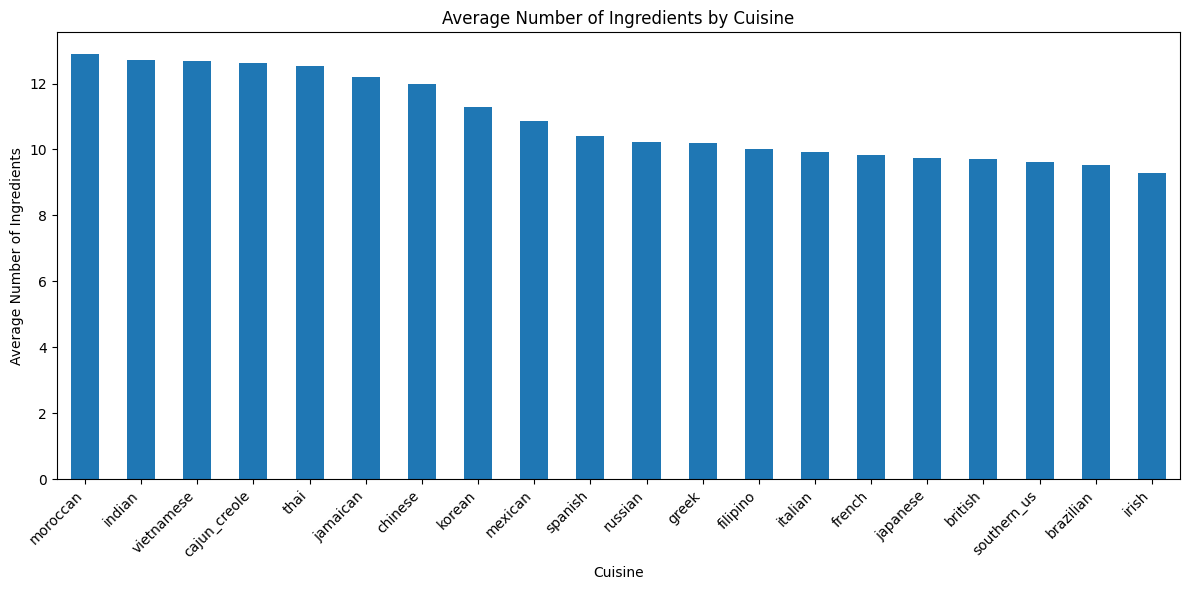

In [30]:
avg_ingredients = train_df.groupby('cuisine')['ingredients'].apply(lambda x: np.mean([len(i) for i in x])).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_ingredients.plot(kind='bar')
plt.title('Average Number of Ingredients by Cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Average Number of Ingredients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Top 10 Ingredients Analysis
Showing the rank, name, frequency, and percentage of the top 10 most common ingredients in the training dataset.

In [31]:
def create_common_ingredients_df(train_df, top_n=10):
    if 'ingredients' in train_df.columns:
        all_ingredients = [item for sublist in train_df['ingredients'] for item in sublist]
        ingredient_freq = Counter(all_ingredients)
        
        top_ingredients = ingredient_freq.most_common(top_n)
        
        data = {
            'Rank': list(range(1, top_n + 1)),
            'Ingredient': [item[0] for item in top_ingredients],
            'Frequency': [item[1] for item in top_ingredients],
            'Percentage': [round((item[1] / len(all_ingredients) * 100), 2) for item in top_ingredients]
        }
        
        return pd.DataFrame(data)
    else:
        raise ValueError("The 'ingredients' column not in the training data.")

try:
    common_ingredients_df = create_common_ingredients_df(train_df, top_n=10)
    common_ingredients_table = create_interactive_table(common_ingredients_df, "Top 10 Most Common Ingredients")
    common_ingredients_table.show()
except ValueError as e:
    print(e)

## Average Ingredients by Cuisine Table
Ranking cuisines based on their average number of ingredients per recipe in the training dataset.

In [32]:
def create_avg_ingredients_df(train_df):
    if 'cuisine' in train_df.columns and 'ingredients' in train_df.columns:
        cuisine_ingredient_count = train_df.groupby('cuisine')['ingredients'].apply(lambda x: np.mean([len(i) for i in x]))
        
        df = cuisine_ingredient_count.reset_index()
        df.columns = ['Cuisine', 'Average Ingredients']
        
        df = df.sort_values('Average Ingredients', ascending=False)
        
        df['Average Ingredients'] = df['Average Ingredients'].round(2)
        
        df['Rank'] = range(1, len(df) + 1)
        
        df = df[['Rank', 'Cuisine', 'Average Ingredients']]
        
        return df
    else:
        raise ValueError("The 'cuisine' or 'ingredients' column not in the training data.")

try:
    avg_ingredients_df = create_avg_ingredients_df(train_df)
    avg_ingredients_table = create_interactive_table(avg_ingredients_df, "Average Number of Ingredients by Cuisine")
    avg_ingredients_table.show()
except ValueError as e:
    print(e)

## Ingredient String Creation
Combines ingredient lists into single strings for both training and test datasets to prepare for text processing.

In [33]:
train_df['ingredients_str'] = train_df['ingredients'].apply(lambda x: ' '.join(x))
test_df['ingredients_str'] = test_df['ingredients'].apply(lambda x: ' '.join(x))

## Ingredient Processing Visualization
Showing the original ingredient lists and their processed string versions for both training and test datasets (first 10 rows each).

In [34]:
#train_df
train_table = create_interactive_table(train_df[['ingredients', 'ingredients_str']].head(10), "Train Data: Original vs Processed Ingredients")
train_table.show()

#test_df
test_table = create_interactive_table(test_df[['ingredients', 'ingredients_str']].head(10), "Test Data: Original vs Processed Ingredients")
test_table.show()

## Recipe Data Processing and Analysis

Displaying initial raw recipe data, processing ingredients into strings, and filtering out entries with empty ingredients.

Displaying of the processed and filtered dataset, followed by a table showing the 20 most common ingredients across all recipes.

In [35]:
def process_set_string(set_str):   
    try:
        ingredients_set = ast.literal_eval(set_str)
      
        return ' '.join(ingredients_set)
    except (ValueError, SyntaxError):
        return ""  

recipes_df = pd.read_csv('../src/input/predicted_ingredients.csv')

recipes_before_table = create_interactive_table(recipes_df.head(10), "Recipes Data: Before Processing")
recipes_before_table.show()


recipes_df['ingredients_str'] = recipes_df['predicted_ingredients'].apply(process_set_string)

recipes_after_table = create_interactive_table(recipes_df[['predicted_ingredients', 'ingredients_str']].head(10), "Recipes Data: After Processing")
recipes_after_table.show()


recipes_df = recipes_df[recipes_df['ingredients_str'] != ""]

recipes_final_table = create_interactive_table(recipes_df.head(10), "Recipes Data: Final (After Filtering)")
recipes_final_table.show()


all_ingredients = ' '.join(recipes_df['ingredients_str']).split()
ingredient_freq = Counter(all_ingredients).most_common(20)
ingredient_freq_df = pd.DataFrame(ingredient_freq, columns=['Ingredient', 'Frequency'])
ingredient_freq_table = create_interactive_table(ingredient_freq_df, "Top 20 Most Common Ingredients")
ingredient_freq_table.show()

## Data Splitting and Distribution Analysis

1. **Data Split**: 
   - Training set: 80% of data
   - Validation set: 20% of data

2. **Sample Display**:
   - Shows first 10 rows of both training and validation sets

3. **Cuisine Distribution**:
   - Creates a table showing the count and percentage of each cuisine in both sets

4. **Dataset Size Summary**:
   - Prints total, training, and validation sample counts with percentages


In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df['ingredients_str'],
    train_df['cuisine'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['cuisine']
)

train_data = pd.DataFrame({'ingredients_str': X_train, 'cuisine': y_train}).reset_index(drop=True)
val_data = pd.DataFrame({'ingredients_str': X_val, 'cuisine': y_val}).reset_index(drop=True)

train_table = create_interactive_table(train_data.head(10), "Training Data Sample (First 10 rows)")
train_table.show()

val_table = create_interactive_table(val_data.head(10), "Validation Data Sample (First 10 rows)")
val_table.show()

train_cuisine_dist = y_train.value_counts().reset_index()
train_cuisine_dist.columns = ['Cuisine', 'Count in Training']
val_cuisine_dist = y_val.value_counts().reset_index()
val_cuisine_dist.columns = ['Cuisine', 'Count in Validation']

cuisine_dist = pd.merge(train_cuisine_dist, val_cuisine_dist, on='Cuisine', how='outer').fillna(0)
cuisine_dist['Training Percentage'] = (cuisine_dist['Count in Training'] / len(y_train) * 100).round(2)
cuisine_dist['Validation Percentage'] = (cuisine_dist['Count in Validation'] / len(y_val) * 100).round(2)

cuisine_dist_table = create_interactive_table(cuisine_dist, "Distribution of Cuisines in Training and Validation Sets")
cuisine_dist_table.show()

print(f"Total samples: {len(train_df)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(train_df)*100:.2f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(train_df)*100:.2f}%)")

Total samples: 39774
Training samples: 31819 (80.00%)
Validation samples: 7955 (20.00%)


## Model Training

Three machine learning models are trained on the preprocessed data:

1. **Random Forest**:
   - Uses CountVectorizer for text preprocessing
   - 100 trees in the forest

2. **Gradient Boosting**:
   - Uses CountVectorizer for text preprocessing
   - 100 boosting stages

3. **Support Vector Machine (SVM)**:
   - Uses TfidfVectorizer for text preprocessing
   - Linear SVM with probability calibration

In [37]:
rf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

gb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])
gb_pipeline.fit(X_train, y_train)

svc_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('classifier', CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=1000), method='sigmoid'))
])
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 CalibratedClassifierCV(estimator=LinearSVC(random_state=42)))])

## Model Evaluation

  **Performance Comparison**:
   - Creating a table comparing the performance metrics (precision, recall, F1-score) for Random Forest, Gradient Boosting, and SVM models on the validation set.

In [38]:
def create_model_performance_df(model, X, y, model_name):
    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df['model'] = model_name
    return df.reset_index().rename(columns={'index': 'metric'})

#performance DataFrames
rf_performance = create_model_performance_df(rf_pipeline, X_val, y_val, 'Random Forest')
gb_performance = create_model_performance_df(gb_pipeline, X_val, y_val, 'Gradient Boosting')
svc_performance = create_model_performance_df(svc_pipeline, X_val, y_val, 'SVC')

# Combine performances
all_performance = pd.concat([rf_performance, gb_performance, svc_performance])

#model performances
performance_table = create_interactive_table(all_performance, "Model Performance Comparison")
performance_table.show()

## Probability Predictions

Generates probability predictions for each model:

1. Random Forest (rf_probs)
2. Gradient Boosting (gb_probs)
3. Support Vector Machine (svc_probs)

These probabilities represent the model's confidence in classifying each cuisine type for the validation set.

In [39]:
rf_probs = rf_pipeline.predict_proba(X_val)
gb_probs = gb_pipeline.predict_proba(X_val)
svc_probs = svc_pipeline.predict_proba(X_val)


## ROC Curve Visualization

Creating ROC (Receiver Operating Characteristic) curve plot:

- Shows curves for Random Forest, Gradient Boosting, and SVM models
- Includes AUC (Area Under Curve) scores for each model
- Compares model performance against random guessing

In [40]:
def plot_roc_curves(y_true, y_probs, model_names):
    
    y_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_bin.shape[1]

    # Computing ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[0][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig = go.Figure()
    for i, model_name in enumerate(model_names):
        fig.add_trace(go.Scatter(x=fpr[0], y=tpr[0],
                                 mode='lines',
                                 name=f'{model_name} (AUC = {roc_auc[0]:.2f})'))

    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines',
                             name='Random Guess',
                             line=dict(dash='dash')))

    fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve',
                      xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate')
    return fig

# ROC curves
roc_fig = plot_roc_curves(y_val, [rf_probs, gb_probs, svc_probs], ['Random Forest', 'Gradient Boosting', 'SVC'])
roc_fig.show()

## Ensemble Model Predictions

Combines prediction probabilities from multiple models (Random Forest, Gradient Boosting, SVM) by averaging, then determines the predicted class for each sample based on the highest probability.

The predicted class indices are then decoded back to cuisine labels using a LabelEncoder.

In [41]:
ensemble_probs = (rf_probs + gb_probs + svc_probs) / 3
ensemble_pred_classes = np.argmax(ensemble_probs, axis=1)

label_encoder = LabelEncoder()
label_encoder.fit(train_df['cuisine'])
ensemble_pred_labels = label_encoder.inverse_transform(ensemble_pred_classes)

## Ensemble Model Evaluation

Box plot of prediction probabilities, a confusion matrix heatmap, and a classification report table for the ensemble model.

These visualizations and metrics provide insights into the model's confidence across cuisines, its accuracy in predictions, and detailed performance metrics for each cuisine class.

In [42]:
#Ensemble Probabilities
def plot_ensemble_probabilities(ensemble_probs, label_encoder):
    df = pd.DataFrame(ensemble_probs, columns=label_encoder.classes_)
    df_melted = df.melt(var_name='Cuisine', value_name='Probability')
    
    fig = go.Figure()
    for cuisine in label_encoder.classes_:
        fig.add_trace(go.Box(y=df[cuisine], name=cuisine))
    
    fig.update_layout(title='Ensemble Model - Prediction Probabilities by Cuisine',
                      yaxis_title='Probability',
                      boxmode='group')
    fig.show()

plot_ensemble_probabilities(ensemble_probs, label_encoder)

#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig = go.Figure(data=go.Heatmap(z=cm, x=classes, y=classes, colorscale='Viridis'))
    fig.update_layout(title='Ensemble Model - Confusion Matrix',
                      xaxis_title='Predicted label',
                      yaxis_title='True label')
    fig.show()

plot_confusion_matrix(y_val, ensemble_pred_labels, label_encoder.classes_)

#Classification Report
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Metric'] + list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df.index] + [df[col] for col in df.columns],
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(title='Ensemble Model - Classification Report')
    fig.show()

plot_classification_report(y_val, ensemble_pred_labels)

## Ensemble Model Performance and Visualizations

Validation accuracy, classification report, confusion matrix heatmap, cuisine distribution charts, model comparison, and feature importance visualization for the ensemble model.

These visualizations provide comprehensive insights into model performance, prediction patterns, and key factors influencing cuisine classification.

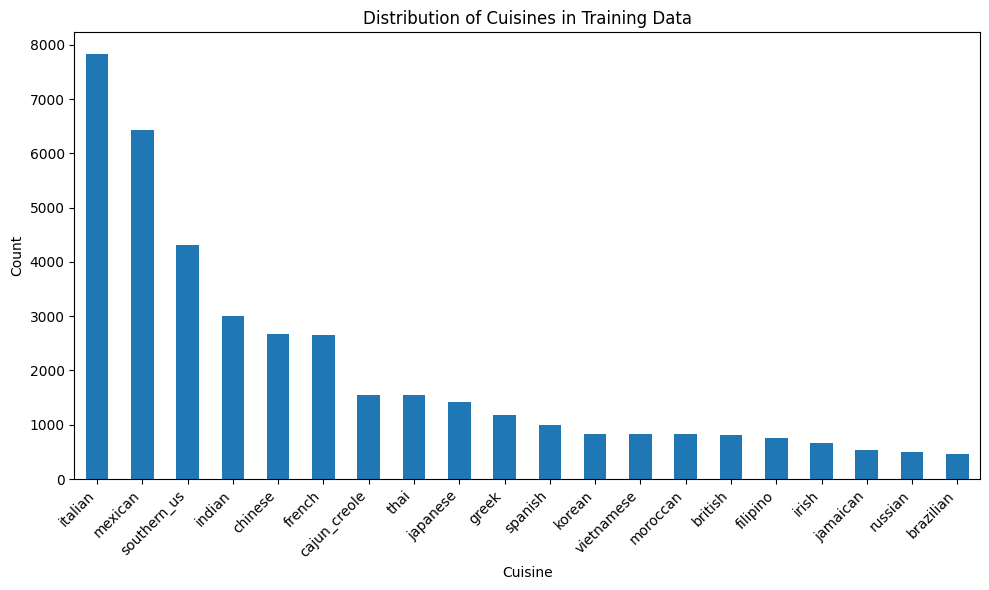

<Figure size 1200x600 with 0 Axes>

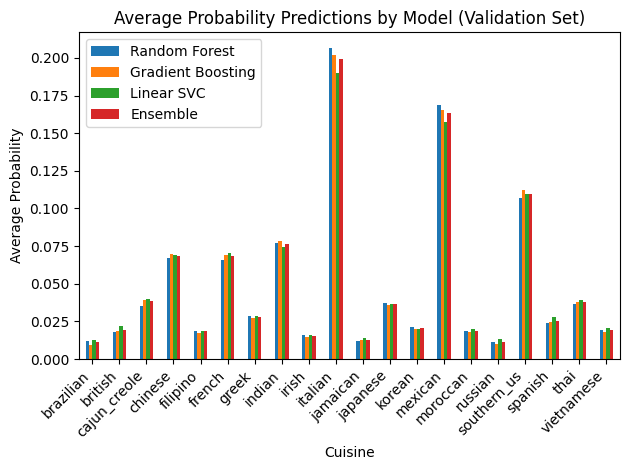

In [43]:
#Cuisine Distribution
plt.figure(figsize=(10, 6))
train_df['cuisine'].value_counts().plot(kind="bar")
plt.title("Distribution of Cuisines in Training Data")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Cuisine Distribution
pred_counts = pd.Series(ensemble_pred_labels).value_counts()
fig_pie = px.pie(
    names=pred_counts.index,
    values=pred_counts.values,
    title="Predicted Cuisine Distribution (Validation Set)",
    hole=0.3
)
fig_pie.update_traces(textinfo='value+percent')
fig_pie.update_layout(
    autosize=False,
    width=800,  
    height=600, 
    margin=dict(l=20, r=20, t=100, b=20) 
)
fig_pie.show()

# Model Comparison
model_probs_df = pd.DataFrame({
    "Cuisine": label_encoder.classes_,
    "Random Forest": rf_probs.mean(axis=0),
    "Gradient Boosting": gb_probs.mean(axis=0),
    "Linear SVC": svc_probs.mean(axis=0),
    "Ensemble": ensemble_probs.mean(axis=0)
})
plt.figure(figsize=(12, 6))
model_probs_df.set_index("Cuisine").plot(kind="bar")
plt.title("Average Probability Predictions by Model (Validation Set)")
plt.ylabel("Average Probability")
plt.xlabel("Cuisine")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

## Model Training and Saving

Random Forest, Gradient Boosting, and Linear SVC models were trained on the full training dataset and saved as separate pickle files.

The Label Encoder used for cuisine encoding was also saved as a pickle file for future use.

In [46]:
RANDOM_FOREST_MODEL_FILE = 'randomforest_model.pkl'
GRADIENT_BOOSTING_MODEL_FILE = 'gradientboosting_model.pkl'
LINEAR_SVC_MODEL_FILE = 'linearsvc_model.pkl'
LABEL_ENCODER_FILE = 'label_encoder.pkl'

rf_pipeline.fit(train_df['ingredients_str'], train_df['cuisine'])
joblib.dump(rf_pipeline, RANDOM_FOREST_MODEL_FILE)

gb_pipeline.fit(train_df['ingredients_str'], train_df['cuisine'])
joblib.dump(gb_pipeline, GRADIENT_BOOSTING_MODEL_FILE)

svc_pipeline.fit(train_df['ingredients_str'], train_df['cuisine'])
joblib.dump(svc_pipeline, LINEAR_SVC_MODEL_FILE)

joblib.dump(label_encoder, LABEL_ENCODER_FILE)
print(f"Models saved as 'src/models/classification/{RANDOM_FOREST_MODEL_FILE}', 'src/models/classification/{GRADIENT_BOOSTING_MODEL_FILE}', 'src/models/classification/{LINEAR_SVC_MODEL_FILE}', and 'src/models/classification/{LABEL_ENCODER_FILE}'")

Models saved as 'src/models/classification/randomforest_model.pkl', 'src/models/classification/gradientboosting_model.pkl', 'src/models/classification/linearsvc_model.pkl', and 'src/models/classification/label_encoder.pkl'


## Training Accuracy Comparison

This bar chart compares the training accuracy of Random Forest, Gradient Boosting, and Linear SVC models, with the y-axis showing accuracy from 0 to 1.

Observations reveal relative performance of models on the training set, with high accuracies suggesting good fit and differences indicating varying model complexity or suitability.

In [48]:
# Predict on training data
rf_train_preds = rf_pipeline.predict(train_df['ingredients_str'])
gb_train_preds = gb_pipeline.predict(train_df['ingredients_str'])
svc_train_preds = svc_pipeline.predict(train_df['ingredients_str'])

# Calculate accuracy
rf_train_acc = accuracy_score(train_df['cuisine'], rf_train_preds)
gb_train_acc = accuracy_score(train_df['cuisine'], gb_train_preds)
svc_train_acc = accuracy_score(train_df['cuisine'], svc_train_preds)

# Visualize training accuracy
model_names = ['Random Forest', 'Gradient Boosting', 'Linear SVC']
train_accuracies = [rf_train_acc, gb_train_acc, svc_train_acc]

fig = px.bar(x=model_names, y=train_accuracies,
             labels={'x': 'Model', 'y': 'Training Accuracy'},
             title="Training Accuracy of Models")
fig.show()

## Confusion Matrices for Model Comparison

Confusion matrices for Random Forest, Gradient Boosting, and SVC models.

Observations show strong diagonal elements indicating good performance, with some off-diagonal elements revealing minor misclassifications between cuisines for each model.

Comparing the matrices reveals strengths and weaknesses of each model in classifying specific cuisines, with diagonal elements representing correct classifications and off-diagonal elements showing misclassifications.

In [49]:
# Confusion matrix for Random Forest
rf_cm = confusion_matrix(train_df['cuisine'], rf_train_preds)
fig_rf_cm = go.Figure(data=go.Heatmap(z=rf_cm,
                                      x=label_encoder.classes_,
                                      y=label_encoder.classes_,
                                      colorscale='Blues'))
fig_rf_cm.update_layout(title="Confusion Matrix - Random Forest",
                        xaxis_title="Predicted",
                        yaxis_title="Actual")
fig_rf_cm.show()

# Confusion matrix for Gradient Boosting
gb_cm = confusion_matrix(train_df['cuisine'], gb_train_preds)
fig_rf_cm = go.Figure(data=go.Heatmap(z=gb_cm,
                                      x=label_encoder.classes_,
                                      y=label_encoder.classes_,
                                      colorscale='Blues'))
fig_rf_cm.update_layout(title="Confusion Matrix - Gradient Boosting",
                        xaxis_title="Predicted",
                        yaxis_title="Actual")
fig_rf_cm.show()

# Confusion matrix for Svc
svc_cm = confusion_matrix(train_df['cuisine'], svc_train_preds)
fig_rf_cm = go.Figure(data=go.Heatmap(z=svc_cm,
                                      x=label_encoder.classes_,
                                      y=label_encoder.classes_,
                                      colorscale='Blues'))
fig_rf_cm.update_layout(title="Confusion Matrix - Svc",
                        xaxis_title="Predicted",
                        yaxis_title="Actual")
fig_rf_cm.show()

## Test Set Predictions and Analysis

Combining ensemble predictions from multiple models to classify cuisines in the test set, with results saved to a CSV file.

A bar chart visualizes the distribution of predicted cuisines, revealing insights into prediction balance and potential biases.

Observations from the chart can indicate model performance and dataset characteristics, highlighting any significant imbalances in cuisine predictions.

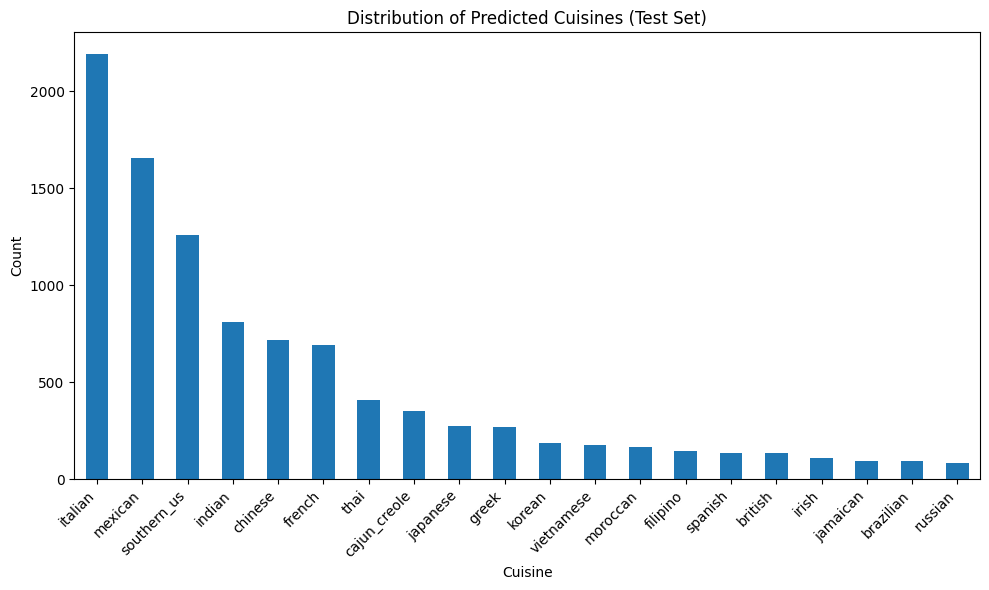

In [50]:
rf_test_probs = rf_pipeline.predict_proba(test_df['ingredients_str'])
gb_test_probs = gb_pipeline.predict_proba(test_df['ingredients_str'])
svc_test_probs = svc_pipeline.predict_proba(test_df['ingredients_str'])
ensemble_test_probs = (rf_test_probs + gb_test_probs + svc_test_probs) / 3
test_pred_classes = np.argmax(ensemble_test_probs, axis=1)
test_df['predicted_cuisine'] = label_encoder.inverse_transform(test_pred_classes)
test_df[['id', 'predicted_cuisine']].to_csv('ensemble_test_predictions.csv', index=False)

#Predicted Cuisine Distribution (Test Set)
plt.figure(figsize=(10, 6))
test_df['predicted_cuisine'].value_counts().plot(kind="bar")
plt.title("Distribution of Predicted Cuisines (Test Set)")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Comprehensive Test Set Analysis

Predicted cuisine distribution, top confident predictions, prediction confidence distribution, model agreement, and a word cloud of ingredients, providing insights into the model's performance and dataset characteristics.

- This reveal frequently predicted cuisines, high-confidence predictions, overall model certainty, inter-model agreement, and dominant ingredients.
- These insights help identify potential biases, assess model reliability, and understand key factors in cuisine classification.

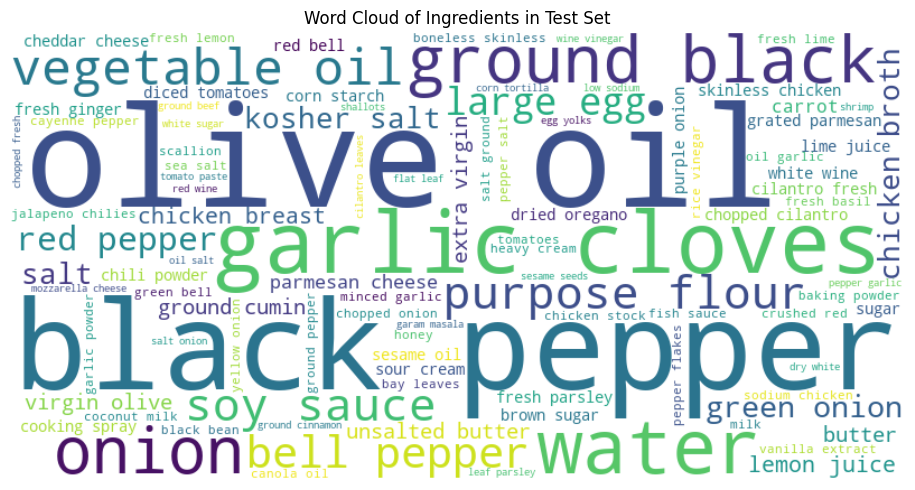

In [51]:
# Distribution of Predicted Cuisines

pred_cuisine_counts = test_df['predicted_cuisine'].value_counts()
fig = px.pie(values=pred_cuisine_counts.values, names=pred_cuisine_counts.index, 
             title='Distribution of Predicted Cuisines', hole=0.3)
fig.update_layout(width=800, height=600)
fig.show()

#Prediction Confidence Distribution
test_df['max_probability'] = np.max(ensemble_test_probs, axis=1)
fig = px.histogram(test_df, x='max_probability', nbins=50,
                   title='Distribution of Prediction Confidence')
fig.update_layout(width=800, height=600)
fig.show()

#Model Agreement Heatmap
def model_agreement(probs1, probs2):
    return np.mean(np.argmax(probs1, axis=1) == np.argmax(probs2, axis=1))

agreement_matrix = np.array([
    [1, model_agreement(rf_test_probs, gb_test_probs), model_agreement(rf_test_probs, svc_test_probs)],
    [model_agreement(gb_test_probs, rf_test_probs), 1, model_agreement(gb_test_probs, svc_test_probs)],
    [model_agreement(svc_test_probs, rf_test_probs), model_agreement(svc_test_probs, gb_test_probs), 1]
])

fig = go.Figure(data=go.Heatmap(
                z=agreement_matrix,
                x=['Random Forest', 'Gradient Boosting', 'SVC'],
                y=['Random Forest', 'Gradient Boosting', 'SVC'],
                colorscale='Viridis'))
fig.update_layout(title='Model Agreement Heatmap', width=800, height=600)
fig.show()

#Ingredients Word Cloud (if you have wordcloud installed)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_ingredients = ' '.join(test_df['ingredients_str'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_ingredients)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Ingredients in Test Set')
plt.tight_layout()
plt.show()

## Analysis of Predicted Cuisines for Recipes Dataset

Distribution of predicted cuisines for the recipes dataset using the ensemble model.

- The chart reveals which cuisines are most commonly predicted in the recipes dataset.
- It helps identify any potential biases or imbalances in the predictions.
- The distribution can be compared with that of the training data to check for consistency.

In [52]:
rf_recipes_probs = rf_pipeline.predict_proba(recipes_df['ingredients_str'])
gb_recipes_probs = gb_pipeline.predict_proba(recipes_df['ingredients_str'])
svc_recipes_probs = svc_pipeline.predict_proba(recipes_df['ingredients_str'])
ensemble_recipes_probs = (rf_recipes_probs + gb_recipes_probs + svc_recipes_probs) / 3
recipes_pred_classes = np.argmax(ensemble_recipes_probs, axis=1)
recipes_df['predicted_cuisine'] = label_encoder.inverse_transform(recipes_pred_classes)
recipes_df.to_csv('ensemble_recipes_with_cuisines.csv', index=False)

#Predicted Cuisine Distribution (Recipes Data)
recipes_counts = recipes_df['predicted_cuisine'].value_counts()
fig_recipes_pie = px.pie(
    names=recipes_counts.index,
    values=recipes_counts.values,
    title="Predicted Cuisine Distribution (Recipes Dataset)",
    hole=0.3
)
fig_recipes_pie.update_layout(width=800, height=600)
fig_recipes_pie.show()

## Predicted Cuisine Distribution for Recipes Dataset (Bar Chart)

Distribution of predicted cuisines for the recipes dataset, offering a different perspective from the previous pie chart.

- The chart clearly shows the relative frequency of each predicted cuisine.
- It allows for easy comparison of counts between different cuisines.
- The height of each bar directly corresponds to the number of recipes predicted for that cuisine.

In [53]:
fig_bar = px.bar(
    x=recipes_counts.index,
    y=recipes_counts.values,
    labels={'x': 'Cuisine', 'y': 'Count'},
    title="Predicted Cuisine Distribution (Recipes Dataset)"
)
fig_bar.update_layout(width=800, height=600)
fig_bar.show()

## Top 5 Predicted Cuisines for Recipes Dataset (Bar Chart)

Five most frequently predicted cuisines in the recipes dataset, providing a more detailed look at the dominant categories.

- The chart clearly highlights the most common cuisine predictions in the dataset.
- It allows for easy comparison between the top predicted cuisines.
- The height of each bar directly corresponds to the number of recipes predicted for that cuisine.

In [54]:
top_cuisines = recipes_counts.head(5)  # Top 5 cuisines
fig_top_cuisines = px.bar(
    x=top_cuisines.index,
    y=top_cuisines.values,
    labels={'x': 'Cuisine', 'y': 'Count'},
    title="Top 5 Predicted Cuisines (Recipes Dataset)"
)
fig_top_cuisines.update_layout(width=800, height=600)
fig_top_cuisines.show()

## Prediction Confidence Analysis
1. **Confidence Distribution**: The histogram shows how prediction confidence scores are distributed across the recipes dataset.
2. **Model Certainty**: Peaks in the distribution indicate common confidence levels, while the spread reveals variability in model certainty.
3. **Insights for Improvement**: This visualization helps identify reliable predictions and areas where the model may need refinement.

In [55]:
recipes_df['max_probability'] = np.max(ensemble_recipes_probs, axis=1)
fig_confidence = px.histogram(
    recipes_df,
    x='max_probability',
    nbins=50,
    title='Distribution of Prediction Confidence (Recipes Dataset)',
    labels={'max_probability': 'Prediction Confidence'}
)
fig_confidence.update_layout(width=800, height=600)
fig_confidence.show()

## Model Testing and Visualization

loads trained models, tests them on predefined examples.
    
The script concludes with a detailed breakdown of top 5 predictions for each example and a summary of overall prediction accuracy.

In [56]:
import pandas as pd
import numpy as np
import joblib
import plotly.express as px
import plotly.graph_objects as go

# Loading the trained models
rf_pipeline = joblib.load('randomforest_model.pkl')
gb_pipeline = joblib.load('gradientboosting_model.pkl')
svc_pipeline = joblib.load('linearsvc_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# test examples
test_examples = [
    {"ingredients": ["rice", "soy sauce", "ginger", "garlic", "green onion"], "expected": "Chinese"},
    {"ingredients": ["pasta", "tomato sauce", "olive oil", "basil", "parmesan"], "expected": "Italian"},
    {"ingredients": ["tortilla", "beans", "chili pepper", "lime", "cilantro"], "expected": "Mexican"},
    {"ingredients": ["rice", "curry powder", "turmeric", "cumin", "yogurt"], "expected": "Indian"},
    {"ingredients": ["butter", "cream", "wine", "thyme", "shallots"], "expected": "French"}
]


def predict_cuisine(ingredients, rf_pipeline, gb_pipeline, svc_pipeline, label_encoder):
    input_str = ' '.join(ingredients)
    rf_probs = rf_pipeline.predict_proba([input_str])[0]
    gb_probs = gb_pipeline.predict_proba([input_str])[0]
    svc_probs = svc_pipeline.predict_proba([input_str])[0]
    ensemble_probs = (rf_probs + gb_probs + svc_probs) / 3
    predicted_class = np.argmax(ensemble_probs)
    predicted_cuisine = label_encoder.inverse_transform([predicted_class])[0]
    confidence_score = ensemble_probs[predicted_class]
    return predicted_cuisine, confidence_score, ensemble_probs


def create_interactive_table(data, title, max_rows=None):
    if max_rows is not None:
        df = data.head(max_rows)
    else:
        df = data

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df.columns),
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[df[col] for col in df.columns],
            fill_color='lavender',
            align='left'
        )
    )])
    fig.update_layout(title=title, width=1000, height=500)
    return fig

# Test each example and store results
results = []
for example in test_examples:
    ingredients = example["ingredients"]
    expected = example["expected"]
    predicted_cuisine, confidence, ensemble_probs = predict_cuisine(
        ingredients, rf_pipeline, gb_pipeline, svc_pipeline, label_encoder
    )
    correct = predicted_cuisine.lower() == expected.lower()  
    results.append({
        "Ingredients": ', '.join(ingredients),
        "Expected Cuisine": expected,
        "Predicted Cuisine": predicted_cuisine,
        "Confidence": round(confidence, 6),  
        "Correct": correct
    })


results_df = pd.DataFrame(results)




results_table = create_interactive_table(results_df, "Test Results for Known Examples")
results_table.show()

# predictions with confidence
fig_bar = px.bar(results_df, x='Ingredients', y='Confidence', color='Correct',
                 text=results_df['Predicted Cuisine'],
                 title='Predicted Cuisines for Known Examples with Confidence',
                 labels={'Confidence': 'Prediction Confidence'},
                 height=600, width=1000)
fig_bar.update_traces(textposition='auto')
fig_bar.add_hline(y=0.5, line_dash="dash", line_color="gray", annotation_text="Confidence Threshold (0.5)")
fig_bar.update_layout(xaxis={'tickangle': 45})
fig_bar.show()

#Detailed probabilities for each example
for i, example in enumerate(test_examples):
    _, _, ensemble_probs = predict_cuisine(example["ingredients"], rf_pipeline, gb_pipeline, svc_pipeline, label_encoder)
    top_5_indices = np.argsort(ensemble_probs)[::-1][:5]
    top_5_cuisines = label_encoder.inverse_transform(top_5_indices)
    top_5_probs = ensemble_probs[top_5_indices]
    
    top_5_df = pd.DataFrame({'Cuisine': top_5_cuisines, 'Probability': top_5_probs})
    fig_detail = px.bar(top_5_df, x='Cuisine', y='Probability',
                        title=f'Top 5 Predictions for: {", ".join(example["ingredients"])} (Expected: {example["expected"]})',
                        text=top_5_df['Probability'].round(4))
    fig_detail.update_traces(textposition='auto')
    fig_detail.update_layout(width=800, height=500)
    fig_detail.show()

# Summary
correct_count = results_df['Correct'].sum()
total_tests = len(results_df)
print(f"\nSummary: {correct_count}/{total_tests} predictions correct ({correct_count/total_tests*100:.2f}%)")


Summary: 5/5 predictions correct (100.00%)


## Batch Cuisine Prediction and Analysis

loading trained models, processing the recipes dataset, and making batch predictions using an ensemble approach.

The final combined results are saved as `recipes_with_predicted_cuisines.csv`, accompanied by summary statistics on prediction confidence.

In [58]:
import pandas as pd
import numpy as np
import joblib
import plotly.express as px
import plotly.graph_objects as go
import ast
from tqdm import tqdm  # For progress bar

# Loading trained models
rf_pipeline = joblib.load('randomforest_model.pkl')
gb_pipeline = joblib.load('gradientboosting_model.pkl')
svc_pipeline = joblib.load('linearsvc_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Loading dataset
recipes_df = pd.read_csv('../src/input/predicted_ingredients.csv')

def process_set_string(set_str):
    try:
        ingredients_set = ast.literal_eval(set_str)
        return ' '.join(ingredients_set)
    except (ValueError, SyntaxError):
        return ""

recipes_df['ingredients_str'] = recipes_df['predicted_ingredients'].apply(process_set_string)
recipes_df = recipes_df[recipes_df['ingredients_str'] != ""]

# Function to predict cuisine in batches
def predict_cuisine_batch(ingredients_list, rf_pipeline, gb_pipeline, svc_pipeline, label_encoder):
    rf_probs = rf_pipeline.predict_proba(ingredients_list)
    gb_probs = gb_pipeline.predict_proba(ingredients_list)
    svc_probs = svc_pipeline.predict_proba(ingredients_list)
    ensemble_probs = (rf_probs + gb_probs + svc_probs) / 3
    predicted_classes = np.argmax(ensemble_probs, axis=1)
    predicted_cuisines = label_encoder.inverse_transform(predicted_classes)
    confidence_scores = ensemble_probs[np.arange(len(ensemble_probs)), predicted_classes]
    return predicted_cuisines, confidence_scores

# Batch processing
batch_size = 10000  
results = []
for start in tqdm(range(0, len(recipes_df), batch_size), desc="Processing batches"):
    end = min(start + batch_size, len(recipes_df))
    batch_df = recipes_df.iloc[start:end]
    ingredients_batch = batch_df['ingredients_str'].tolist()
    
    predicted_cuisines, confidences = predict_cuisine_batch(
        ingredients_batch, rf_pipeline, gb_pipeline, svc_pipeline, label_encoder
    )
    
    batch_results = pd.DataFrame({
        "Ingredients": ingredients_batch,
        "Predicted Cuisine": predicted_cuisines,
        "Confidence": confidences.round(6)
    })
    results.append(batch_results)
    

    batch_results.to_csv(f'recipes_with_predicted_cuisines_batch_{start}.csv', index=False)


results_df = pd.concat(results, ignore_index=True)

# (first 50 rows)
results_table = create_interactive_table(results_df, "Predicted Cuisines for Recipes Dataset", max_rows=50)
results_table.show()

# cuisine distribution
cuisine_counts = results_df['Predicted Cuisine'].value_counts().reset_index()
cuisine_counts.columns = ['Cuisine', 'Count']
fig_dist = px.bar(cuisine_counts, x='Cuisine', y='Count',
                  title='Distribution of Predicted Cuisines in Recipes Dataset',
                  text=cuisine_counts['Count'],
                  height=600, width=1000)
fig_dist.update_traces(textposition='auto')
fig_dist.update_layout(xaxis={'tickangle': 45})
fig_dist.show()

#Confidence distribution histogram
fig_conf = px.histogram(results_df, x='Confidence', nbins=50,
                        title='Distribution of Prediction Confidence Scores',
                        height=600, width=1000)
fig_conf.update_layout(bargap=0.1)
fig_conf.show()

#combined results
results_df.to_csv('recipes_with_predicted_cuisines.csv', index=False)
print(f"Predictions saved to 'recipes_with_predicted_cuisines.csv'")
print(f"Total recipes processed: {len(results_df)}")

# Summary
print("\nSummary Statistics:")
print(f"Average Confidence: {results_df['Confidence'].mean():.4f}")
print(f"Minimum Confidence: {results_df['Confidence'].min():.4f}")
print(f"Maximum Confidence: {results_df['Confidence'].max():.4f}")

Processing batches: 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]


Predictions saved to 'recipes_with_predicted_cuisines.csv'
Total recipes processed: 29999

Summary Statistics:
Average Confidence: 0.4354
Minimum Confidence: 0.1034
Maximum Confidence: 0.9908
